In [ ]:
%matplotlib inline 

This demo builds a few toy models for classifying handwritten digitis with high accuracy. It is a modification of a notebook build by Daniel Moser, with resoures by Xavier Snelgrove and Yash Kataria. 

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [ ]:
import numpy as np                   # math functions 
import matplotlib.pyplot as plt      # plotting
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset 
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools


In [ ]:
#!pip install tensorflow==2.5
import tensorflow as tf

## Loading Training Data



In [ ]:

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


170508288/170498071 [==============================] - 11s 0us/step


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[2]')

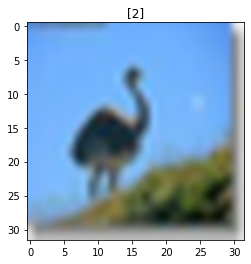

In [ ]:

num = random.randint(0, len(X_train)) #generate a random integer
plt.imshow(X_train[num], interpolation='spline36') #plot an image with the index generated at previous step
                                                              # cmap='grey' controls how the pixel values 0-255 are mapped to images
                                                              # interpolation='none' is needed to display the image properly because 
                                                              # plt.imshow() actually makes a number of modifications in the desire to correct
                                                              # various sampling artifacts
plt.title(y_train[num])



Let's examine a single digit a little closer, and print out the array representing the last digit.

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. 

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [ ]:
X_train = X_train.reshape(50000, 3072) 
X_test = X_test.reshape(10000, 3072)   

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (50000, 3072)
Testing matrix shape (10000, 3072)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [ ]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

In [ ]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

## The first hidden layer

In [ ]:
# The first hidden layer is a set of 512 neurons.


model.add(Dense(1024, input_shape=(3072,)))  #Dense means the layer is fully connected (every input goes to every output)

In [ ]:


model.add(Activation('relu'))

## Adding the second hidden layer

In [ ]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(1024))
model.add(Activation('relu'))


## The Final Output Layer

In [ ]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [ ]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [ ]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_1 (Activation)   (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                10250     
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 4,206,602
Trainable params: 4,206,602
Non-

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.


In [ ]:
# Model parameters
#model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [ ]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=7,
          verbose=1) #note that the batches are not actually chosen randomly, but rather the method goes through the data set sequentially
                     # can sort of change that by including the parameter shuffle=true, which randomly shuffles the traininst  set first
                     # an epoch is a complete pass through the whole data set
                     # verbose = 1 gives you an animated progress bar

Epoch 1/7
391/391 [==============================] - 6s 8ms/step - loss: 1.9192 - accuracy: 0.3190
Epoch 2/7
391/391 [==============================] - 3s 8ms/step - loss: 1.6628 - accuracy: 0.4064
Epoch 3/7
391/391 [==============================] - 3s 8ms/step - loss: 1.5778 - accuracy: 0.4394
Epoch 4/7
391/391 [==============================] - 3s 8ms/step - loss: 1.5082 - accuracy: 0.4620
Epoch 5/7
391/391 [==============================] - 3s 8ms/step - loss: 1.4701 - accuracy: 0.4748
Epoch 6/7
391/391 [==============================] - 3s 8ms/step - loss: 1.4296 - accuracy: 0.4907
Epoch 7/7
391/391 [==============================] - 3s 8ms/step - loss: 1.3994 - accuracy: 0.5044


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 4ms/step - loss: 1.4492 - accuracy: 0.4837
Test score: 1.4492006301879883
Test accuracy: 0.4837000072002411


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [ ]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_temp = model.predict(X_test)
predicted_classes=np.argmax(predicted_temp,axis=1)

# Check which items we got right / wrong

correct_indices = [] 
incorrect_indices = []

for i in range(len(predicted_classes)):
  if predicted_classes[i] == y_test[i]:
    correct_indices.append(i)
  else:
    incorrect_indices.append(i)





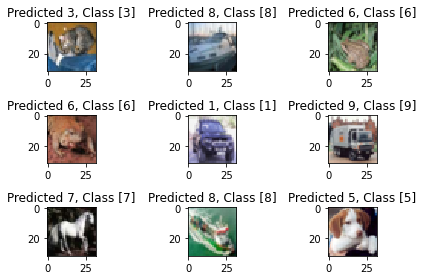

In [ ]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(32,32,3), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(32,32,3), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()